Create a dataframe with retrieve Tweets from 2022-23

In [4]:
import pandas as pd
import json

# read the JSONL file
with open('data/activity_congress_2.jsonl', 'r', encoding='utf8') as f:
    lines = f.readlines()

# convert each JSON object to a dictionary and store in a list
data = []
for line in lines:
    data.append(json.loads(line))

# create a dataframe from the list of dictionaries
df = pd.DataFrame(data)

In [5]:
tweets = []
for tweet in df['data']:
    for t in tweet:
        tweet_dict = {}
        tweet_dict['user_id'] = t['author_id']
        tweet_dict['text'] = t['text']
        tweet_dict['created_at'] = t['created_at']
        tweets.append(tweet_dict)

df_tweets = pd.DataFrame(tweets)

In [6]:
df_tweets.to_csv('tweets_congress.csv', index=False)

Convert to word embedded vectors using SBERT. Generate K clusters. Each cluster ‘motive’ is a node

In [7]:
import pandas as pd
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

tweets = pd.read_csv('tweets_congress.csv')


In [8]:
import preproc_functions as preproc
# apply standard preprocessing
tweets['pp_text'] = tweets['text'].apply(preproc.preprocess_text)
#add stopwords that occur once in in >=50% of documents
tweets = preproc.remove_common_words(tweets, 'pp_text', 'user_id', threshold=0.5)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ghias\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ghias\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ghias\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
embeddings = model.encode(tweets['pp_text'])

In [10]:
import pandas as pd
from scipy.cluster.vq import kmeans, vq

# cluster the embeddings
k = 6
centroids, distortion = kmeans(embeddings, k)
clusters, _ = vq(embeddings, centroids)

# Assign each tweet to its corresponding cluster
tweets['cluster'] = clusters

In [11]:
tweets

,user_id,text,created_at,pp_text,cluster
0,1074518754,"This past year, Congressional Dems worked hard...",2022-12-30T16:01:00.000Z,past year congression dem work hard lower heal...,2
1,1074518754,Today marks the first day of #Kwanzaa! I’m wis...,2022-12-26T15:45:59.000Z,today mark first day kwanzaa im wish celebr wi...,4
2,1074518754,Merry Christmas and happy holidays Wisconsin! ...,2022-12-25T16:11:25.000Z,merri christma happi holiday wisconsin httpstc...,3
3,1074518754,Happy holidays to the brave men &amp; women in...,2022-12-23T17:54:20.000Z,happi holiday brave men amp woman arm forc ser...,4
4,1074518754,My Statement on the Senate’s Omnibus passage: ...,2022-12-22T19:29:26.000Z,statement senat omnibu passag httpstcordupgatm,0
...,...,...,...,...,...
21098,13218102,#BidenBorderCrisis https://t.co/QbisajChIn,2022-08-25T20:48:26.000Z,bidenbordercrisi httpstcoqbisajchin,0
21099,13218102,RT @KellyO: WH cannot say how much the student...,2022-08-25T17:45:14.000Z,rt kellyo wh say much student loan forgiv plan...,5
21100,13218102,"With IRS Funding, Democrats Plan To Audit the ...",2022-08-25T17:42:19.000Z,ir fund democrat plan audit middl class httpst...,5
21101,13218102,Great to visit @TAMUHealth Center of Excellenc...,2022-08-25T17:40:45.000Z,great visit tamuhealth center excel forens nur...,3


In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k = 6
kmeans_model = KMeans(n_clusters=k, random_state=42)
kmeans_model.fit(embeddings)

# calculate silhouette score
silhouette_avg = silhouette_score(embeddings, kmeans_model.labels_)
print("Silhouette Score:", silhouette_avg)

# calculate within-cluster sum of squares (WSS)
wss = kmeans_model.inertia_
print("Within-cluster sum of squares (WSS):", wss)


C:\Users\ghias\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.047955923
Within-cluster sum of squares (WSS): 2062834.25


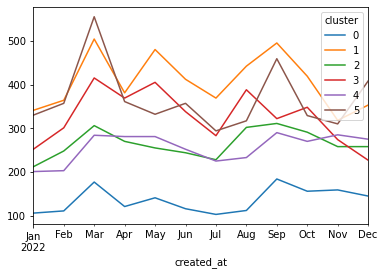

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# assume your dataframe is named 'df'
# step 1
tweets['created_at'] = pd.to_datetime(tweets['created_at'])

# step 2
tweets.set_index('created_at', inplace=True)

# step 3 and 4
counts = tweets.groupby('cluster').resample('M').count()

# step 5
counts = counts['user_id'].unstack('cluster')

# step 6
counts.plot(kind='line')
plt.show()


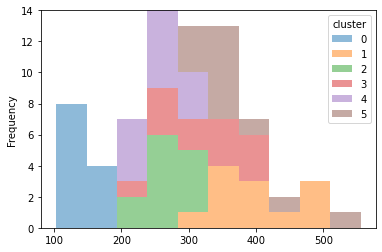

In [14]:
counts.plot(kind='hist', stacked=True, alpha=0.5, bins=10)
plt.show()

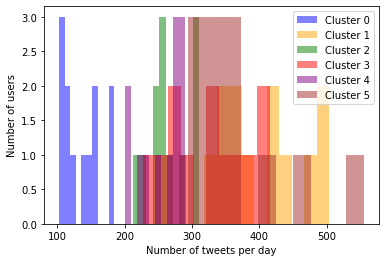

In [15]:
# step 6
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'teal', 'navy', 'maroon']
for i, col in enumerate(counts.columns):
    plt.hist(counts[col], bins=10, alpha=0.5, label=f'Cluster {col}', color=colors[i])

plt.legend()
plt.xlabel('Number of tweets per day')
plt.ylabel('Number of users')
plt.show()

Using text mining techniques such as topic modeling to automatically identify the main topics in each cluster.

In [32]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# create a bag-of-words representation of the text data
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(tweets['pp_text'])

# set the number of topics
n_topics = 6

# train an LDA model
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

# get the topic probabilities for each document
doc_topic_probs = lda.transform(X)

# print the top words for each topic
topics = []
for topic_idx, topic in enumerate(lda.components_):
    top_words = []
    for i in range(len(vectorizer.vocabulary_)):
        if vectorizer.vocabulary_[list(vectorizer.vocabulary_.keys())[i]] == topic.argsort()[:-len(vectorizer.vocabulary_)-1:-1][0]:
            top_words.append(list(vectorizer.vocabulary_.keys())[i])
    topics.append(top_words)

# assign the main topic to each tweet
main_topic = []
for i in range(len(doc_topic_probs)):
    topic_probs = doc_topic_probs[i]
    main_topic_idx = np.argmax(topic_probs)
    main_topic.append(topics[main_topic_idx][0] if topics[main_topic_idx] else "")

# add the main topic column to the tweets dataframe
tweets['main_topic_6.1'] = main_topic

topics_6 = topics.copy()

In [33]:
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')


def preprocess_text(text):
    # convert to lowercase
#     text = text.lower()
    # tokenize
    tokens = word_tokenize(text)
#     # remove punctuation
#     tokens = [token for token in tokens if token not in string.punctuation]
#     # remove stopwords
#     tokens = [token for token in tokens if token not in stopwords.words('english')]
#     # lemmatize
#     lemmatizer = WordNetLemmatizer()
#     tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # return list of tokens
    return tokens

tweets['pp_text_tok'] = tweets['pp_text'].apply(preprocess_text)

# create a dictionary from the text data
dictionary = gensim.corpora.Dictionary(tweets['pp_text_tok'])

# create a corpus from the bag-of-words representation
corpus = [dictionary.doc2bow(text) for text in tweets['pp_text_tok']]

# create the LDA model
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=6, iterations=500)

# calculate the coherence score for the LDA model
coherence_model_lda = CoherenceModel(model=lda, texts=tweets['pp_text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_lda:.3f}')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ghias\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Coherence Score: nan


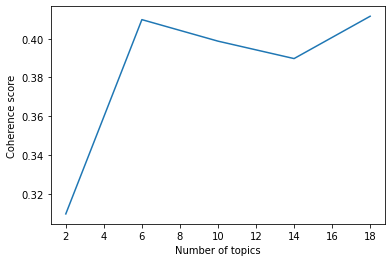

In [35]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt

# create a dictionary and bag-of-words representation of the text data
texts = [tweet.split() for tweet in tweets['pp_text']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# define the range of topics to explore
start_topic = 2
end_topic = 20

# initialize variables to store coherence scores and main topics
coherence_scores = []
main_topics = []

# iterate through different number of topics
for n_topics in range(start_topic, end_topic+1,4):

    # train an LDA model
    lda = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary)

    # get the topic probabilities for each document
    doc_topic_probs = lda.get_document_topics(corpus)

    # assign the main topic to each tweet
    main_topic = []
    for i, doc in enumerate(doc_topic_probs):
        main_topic_idx = max(doc, key=lambda x: x[1])[0]
        main_topic.append(main_topic_idx)

    # add the main topic column to the tweets dataframe
    tweets[f'main_topic_{n_topics}'] = main_topic

    # calculate the topic coherence score for the LDA model
    coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    
    # append coherence score and main topic to lists
    coherence_scores.append(coherence_lda)
    main_topics.append(n_topics)

# plot coherence score vs number of topics
plt.plot(main_topics, coherence_scores)
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.show()

In [41]:
# reset the index to a new column and rename it
tweets = tweets.reset_index().rename(columns={'index': 'created_at'})

In [61]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import re

def get_lda_topics(lda_model, num_topics):
    word_dict = {}
    for i in range(num_topics):
        words = lda_model.show_topic(i, topn = 5)
        word_dict[i] = [word[0] for word in words]
    return word_dict


# define the regular expression pattern to match 'rt' and 'amp' in the text
rt_amp_pattern = re.compile(r'\b(rt|amp)\b')

# preprocess the text data by removing stopwords, rt, and amp
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
preprocessed_texts = []
for tweet in tweets['pp_text']:
    # remove rt and amp
    tweet = rt_amp_pattern.sub('', tweet)
    # tokenize and remove stopwords
    tokens = [token for token in tokenizer.tokenize(tweet.lower()) if token not in stop_words]
    preprocessed_texts.append(tokens)

# create a dictionary and bag-of-words representation of the preprocessed text data
dictionary = Dictionary(preprocessed_texts)
corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]


# train an LDA model with n_topics=6
n_topics = 6
lda = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary)

# get the topic probabilities for each document
doc_topic_probs = lda.get_document_topics(corpus)

# define the topic words for each topic
topic_words = get_lda_topics(lda, n_topics)

# assign the main topic concept to each tweet
main_topic_concept = []
for doc in doc_topic_probs:
    main_topic_idx = max(doc, key=lambda x: x[1])[0]
    main_topic_concept.append(topic_words[main_topic_idx])

# add the main topic concept column to the tweets dataframe
tweets['main_topic_6_LDA'] = main_topic_concept

In [75]:
unique_topics = tweets['main_topic_6_LDA'].apply(tuple).unique()

In [76]:
unique_topics

array([('work', 'famili', 'child', 'live', 'act'),
       ('via', 'year', 'day', 'nation', 'u'),
       ('senat', 'act', 'right', 'health', 'bill'),
       ('infrastructur', 'fund', 'commun', 'thank', 'help'),
       ('ukrain', 'vote', 'putin', 'russia', 'court'),
       ('biden', 'american', 'border', 'energi', 'inflat')], dtype=object)

In [82]:
#tweets = tweets.drop(['main_topic_6.1', 'pp_text_tok', 'main_topic_12.1', 'main_topic_6', 'main_topic_12',                      'main_topic_18', 'main_topic_24', 'main_topic_30', 'main_topic_36', 'main_topic_42',                      'main_topic_48', 'main_topic_2', 'main_topic_10', 'main_topic_14', 'pp_text_LDA'], axis=1)
tweets['main_topic_6_LDA'] = tweets['main_topic_6_LDA'].apply(tuple)
tweets['topic_6_LDA'] = pd.factorize(tweets['main_topic_6_LDA'])[0]


In [84]:
#tweets.to_csv('tweets_classified_1.csv', index=False)

In [86]:
tweets.columns

Index(['created_at', 'user_id', 'text', 'pp_text', 'cluster', 'topic_6_LDA',
       'main_topic_6_LDA'],
      dtype='object')

In [90]:
tweets['created_at']

,created_at,user_id,text,pp_text,cluster,topic_6_LDA,main_topic_6_LDA
0,2022-12-30 16:01:00+00:00,1074518754,"This past year, Congressional Dems worked hard...",past year congression dem work hard lower heal...,2,0,"(work, famili, child, live, act)"
1,2022-12-26 15:45:59+00:00,1074518754,Today marks the first day of #Kwanzaa! I’m wis...,today mark first day kwanzaa im wish celebr wi...,4,1,"(via, year, day, nation, u)"
2,2022-12-25 16:11:25+00:00,1074518754,Merry Christmas and happy holidays Wisconsin! ...,merri christma happi holiday wisconsin httpstc...,3,1,"(via, year, day, nation, u)"
3,2022-12-23 17:54:20+00:00,1074518754,Happy holidays to the brave men &amp; women in...,happi holiday brave men amp woman arm forc ser...,4,1,"(via, year, day, nation, u)"
4,2022-12-22 19:29:26+00:00,1074518754,My Statement on the Senate’s Omnibus passage: ...,statement senat omnibu passag httpstcordupgatm,0,2,"(senat, act, right, health, bill)"
...,...,...,...,...,...,...,...
21098,2022-08-25 20:48:26+00:00,13218102,#BidenBorderCrisis https://t.co/QbisajChIn,bidenbordercrisi httpstcoqbisajchin,0,4,"(ukrain, vote, putin, russia, court)"
21099,2022-08-25 17:45:14+00:00,13218102,RT @KellyO: WH cannot say how much the student...,rt kellyo wh say much student loan forgiv plan...,5,5,"(biden, american, border, energi, inflat)"
21100,2022-08-25 17:42:19+00:00,13218102,"With IRS Funding, Democrats Plan To Audit the ...",ir fund democrat plan audit middl class httpst...,5,5,"(biden, american, border, energi, inflat)"
21101,2022-08-25 17:40:45+00:00,13218102,Great to visit @TAMUHealth Center of Excellenc...,great visit tamuhealth center excel forens nur...,3,3,"(infrastructur, fund, commun, thank, help)"


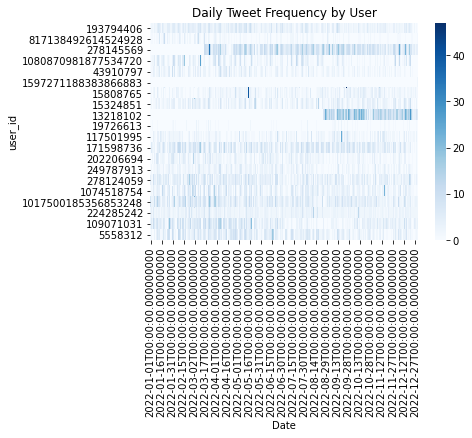

In [110]:
# pivot table with daily count of tweets
pivot_table = tweets.pivot_table(values='text', index='user_id', columns='created_at', aggfunc='count', fill_value=0)

# convert column names to datetime format
pivot_table.columns = pd.to_datetime(pivot_table.columns, format='%d%m%Y', errors='coerce')

# sort the columns in ascending order
pivot_table = pivot_table.sort_values(by=pivot_table.columns.tolist()[0])

# plot heatmap of pivot table
#plt.figure(figsize=(10,25))
sns.heatmap(pivot_table, cmap='Blues', cbar=True)
plt.xlabel('Date')
plt.title('Daily Tweet Frequency by User')
plt.show()


<ipython-input-113-43acc5588f3b>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  tweets['week'] = tweets['created_at'].dt.week


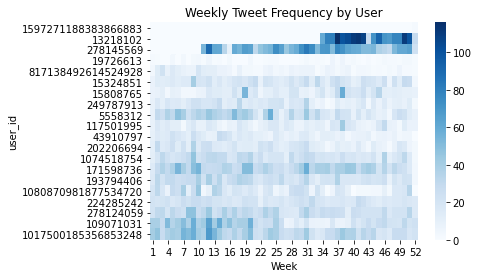

In [113]:
# create a new column with the week number
tweets['week'] = tweets['created_at'].dt.week

# pivot table with weekly count of tweets
pivot_table = tweets.pivot_table(values='pp_text', index='user_id', columns='week', aggfunc='count', fill_value=0)

# sort the columns in ascending order
pivot_table = pivot_table.sort_values(by=pivot_table.columns.tolist()[0])

# plot heatmap of pivot table
sns.heatmap(pivot_table, cmap='Blues', cbar=True)
plt.xlabel('Week')
plt.title('Weekly Tweet Frequency by User')
plt.show()

<ipython-input-115-afc2ebd3530a>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  tweets['week'] = tweets['created_at'].dt.week


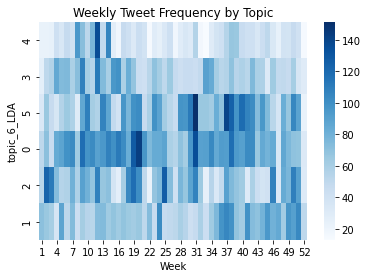

In [115]:
# create a new column with the week number
tweets['week'] = tweets['created_at'].dt.week

# pivot table with weekly count of tweets
pivot_table = tweets.pivot_table(values='pp_text', index='topic_6_LDA', columns='week', aggfunc='count', fill_value=0)

# sort the columns in ascending order
pivot_table = pivot_table.sort_values(by=pivot_table.columns.tolist()[0])

# plot heatmap of pivot table
sns.heatmap(pivot_table, cmap='Blues', cbar=True)
plt.xlabel('Week')
plt.title('Weekly Tweet Frequency by Topic')
plt.show()